In [76]:
import pandas as pd
from datetime import timedelta, datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import numpy as np
from tqdm import tqdm

In [77]:
interval_time = 7200

# Format into set ready for training and eval
df = pd.read_csv("feat_eng_"+str(interval_time)+".csv")

# Days in the past
days_in_past = 0

# [{ID, [entries], label}]
X = []
Y = []

# Store max call and sms for later normalization
max_call = df["call"].max()
max_sms = df["sms"].max()

df["timestamp"] = pd.to_datetime(df["timestamp"])

for id in df["ID"].unique():
    df_id = df[df["ID"] == id]
    for day in df_id["timestamp"].dt.floor("D").unique():
        
        df_id_days = df_id[((df_id["timestamp"].dt.date <= day.date()) & (df_id["timestamp"].dt.date >= (day - timedelta(days=days_in_past)).date()))].sort_values(by="timestamp", ascending=False)
        label = df_id_days["next_mood"].iloc[0]
        df_id_days = df_id_days.sort_values(by="timestamp", ascending=True).drop(columns=["ID"])

        # being an RNN, timestamp shouldn't be needed since the order is the important
        df_id_days["timestamp"] = df_id_days["timestamp"].astype(int) // 10**11
        df_id_days["timestamp"] = df_id_days["timestamp"] - df_id_days["timestamp"].min()

        df_id_days = df_id_days.drop(columns="Unnamed: 0").reset_index(drop=True)

        # Normalize values
        # Normalize mood, mood_day-1, mood_day-2, next_mood [1:10]
        for col in ["mood", "mood_day-1", "mood_day-2", "next_mood"]:
            df_id_days[col] = (df_id_days[col] - 1)/(10-1)
        # Normalize arousal and valence [-2;2]
        df_id_days["arousal"] = (df_id_days["arousal"] - (-2))/(2 - (-2))
        df_id_days["valence"] = (df_id_days["valence"] - (-2))/(2 - (-2))
        # Activity is already normalized
        # Normalize call, sms [0; max_call], [0; max_sms]
        df_id_days["call"] = (df_id_days["call"] - 0)/(max_call - 0)
        df_id_days["sms"] = (df_id_days["sms"] - 0)/(max_sms - 0)
        # Normalize screen, appCat.X
        timeBasedFields = ['screen', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other','appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities','appCat.weather']
        for col in timeBasedFields:
            df_id_days[col] = (df_id_days[col] - 0)/(interval_time - 0)
            
        # Using only one value since it will be the next day predicted value
        X.append(df_id_days.drop(columns=["next_mood", "timestamp"]).values)
        Y.append(df_id_days["next_mood"][0])

        #raw_tuples = list(df_id_days.itertuples(index=False, name=None))
        #print(len(raw_tuples[0]))
        #data.append({"ID": id, "entries": raw_tuples, "label": label})


In [78]:
import random

# Assuming X and Y are lists of values
X_array = np.array(X, dtype=np.float32)
Y_array = np.array(Y, dtype=np.float32)

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X_array)
Y_tensor = torch.tensor(Y_array)

# Removing nan
X_tensor = torch.where(torch.isnan(X_tensor), torch.zeros_like(X_tensor), X_tensor)
Y_tensor = torch.where(torch.isnan(Y_tensor), torch.zeros_like(Y_tensor), Y_tensor)

dataset = TensorDataset(X_tensor, Y_tensor)

train_size = int(0.75*len(X))
test_size = len(X) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#print(X_tensor.shape)
#print(Y_tensor.shape)

In [79]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes  # output size
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected 
        self.fc_2 = nn.Linear(128, num_classes)  # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # (input, hidden, and cell state)
        hn = hn[-1]  # last layer's hidden state
        out = self.relu(hn)
        out = self.fc_1(out)  # first dense
        out = self.relu(out)  # relu
        out = self.fc_2(out)  # final output
        return out

########################################################################################################################################################

def training_loop(n_epochs, lstm, optimiser, loss_fn, train_loader, test_loader):
    
    for epoch in range(n_epochs):
        outputs_return = []
        labels_return = []
        for inputs, label in train_loader:
            # Training mode
            lstm.train() 
            # Reset gradients
            optimiser.zero_grad()
            # Forward propagation
            outputs = lstm(inputs)
            # Training loss
            loss = loss_fn(outputs, label) 
            # Backpropagate
            loss.backward()
            # Update weights
            torch.nn.utils.clip_grad_norm_(lstm.parameters(), max_norm=1)
            optimiser.step() 

        # Evaluation mode
        lstm.eval() 
        # Disable gradient calc
        with torch.no_grad():
            test_loss = 0.0
            # Compute classes and losses
            for inputs, labels in test_loader:
                outputs = lstm(inputs)
                outputs_return.append(outputs)
                labels_return.append(labels)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            
        test_loss /= len(test_loader.dataset)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, train loss: {loss.item():.5f}, test loss: {test_loss:.5f}")
            #print("Result std: "+str(np.std(np.array((10-1)*y_test+1))))
            #print("Prediction std: "+str(np.std(np.array((10-1)*test_preds+1))))

    return outputs_return, labels_return

########################################################################################################################################################


Testing learning rate: 0.001, features in hidden layer 5, stacked LSTM 1
Epoch: 0, train loss: 0.18921, test loss: 0.22102
Epoch: 10, train loss: 0.00012, test loss: 0.00634
Epoch: 20, train loss: 0.00028, test loss: 0.00631
Epoch: 30, train loss: 0.00034, test loss: 0.00636
Epoch: 40, train loss: 0.00086, test loss: 0.00623
Epoch: 50, train loss: 0.00061, test loss: 0.00638
Epoch: 60, train loss: 0.00117, test loss: 0.00623
Epoch: 70, train loss: 0.00246, test loss: 0.00636
MSE: 0.508482294293794
MAE: 0.547978037251876
R-squared: 0.007662836218217839
Testing learning rate: 0.001, features in hidden layer 5, stacked LSTM 2
Epoch: 0, train loss: 0.06754, test loss: 0.10021
Epoch: 10, train loss: 0.00199, test loss: 0.00627
Epoch: 20, train loss: 0.00165, test loss: 0.00631
Epoch: 30, train loss: 0.00146, test loss: 0.00634
Epoch: 40, train loss: 0.00219, test loss: 0.00628
Epoch: 50, train loss: 0.00168, test loss: 0.00631
Epoch: 60, train loss: 0.00236, test loss: 0.00629
Epoch: 70, tr

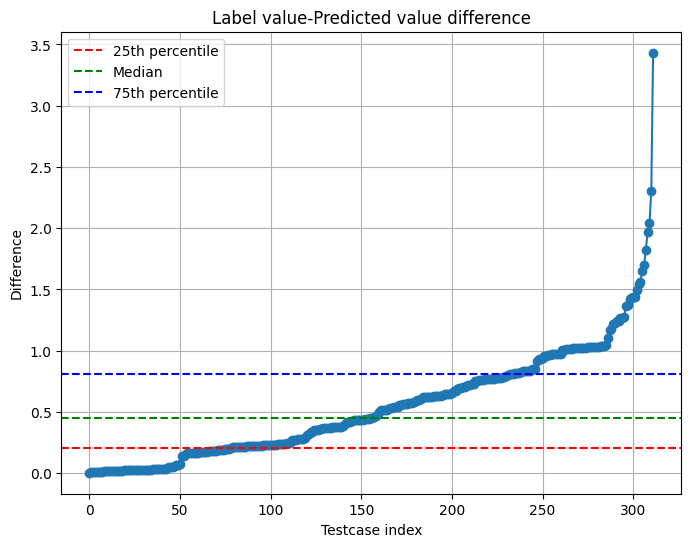

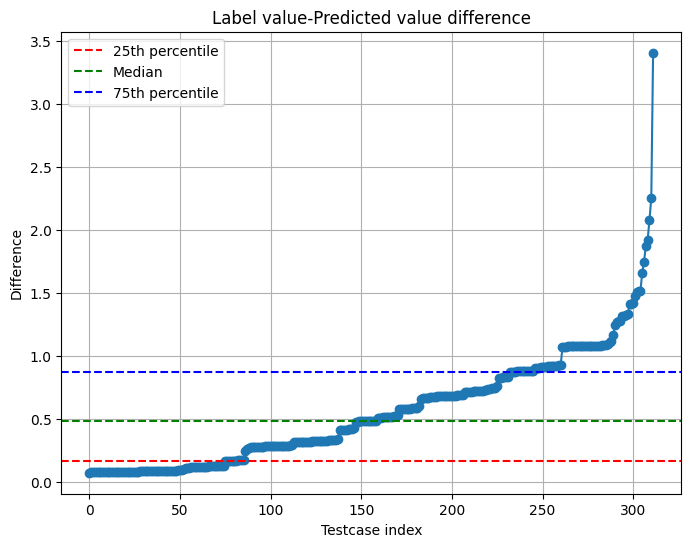

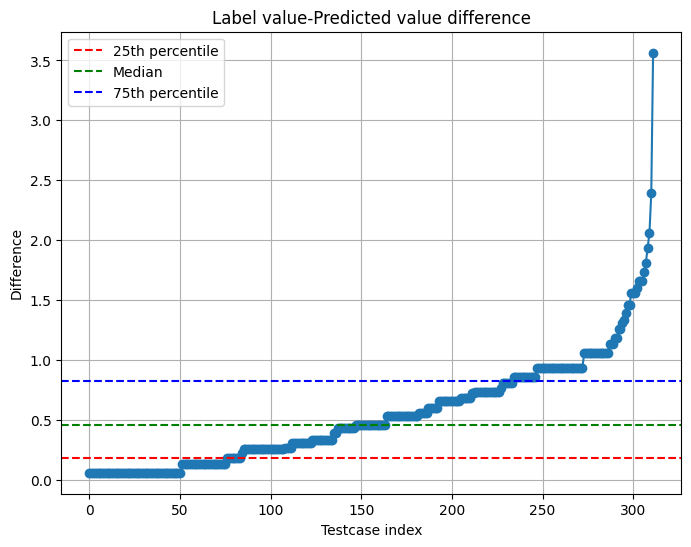

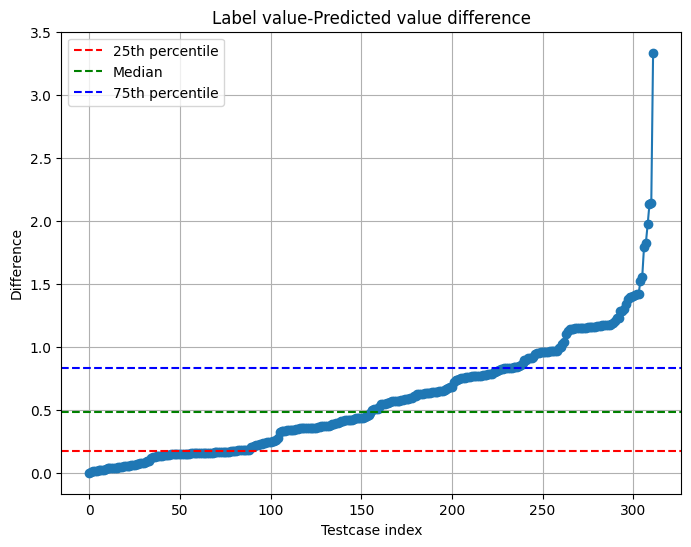

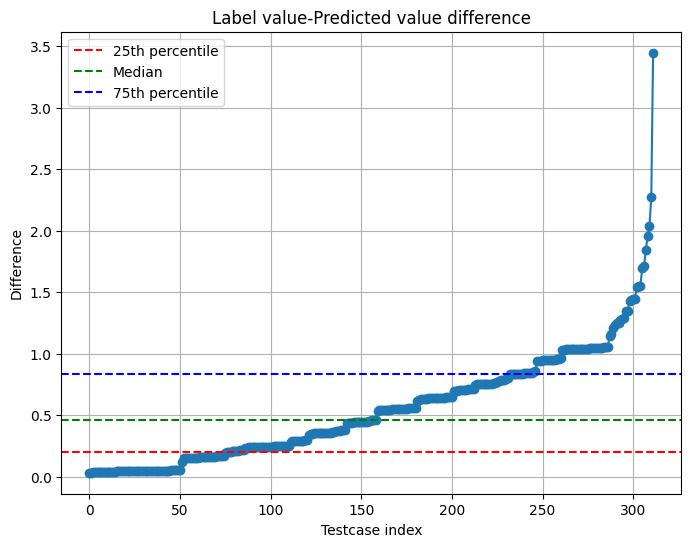

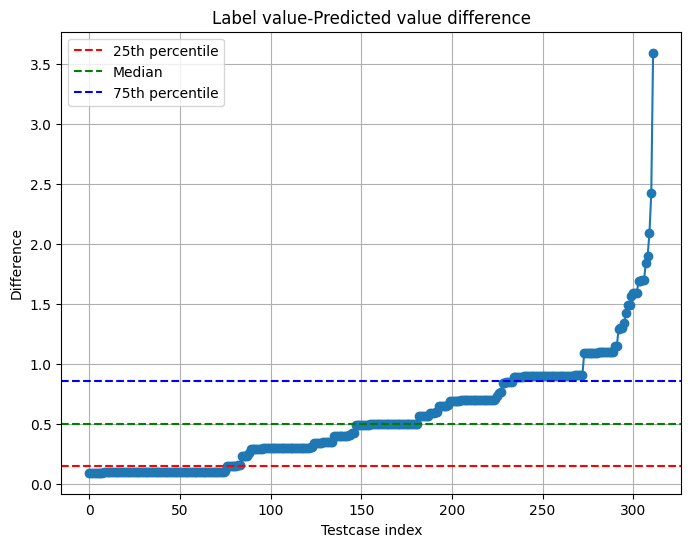

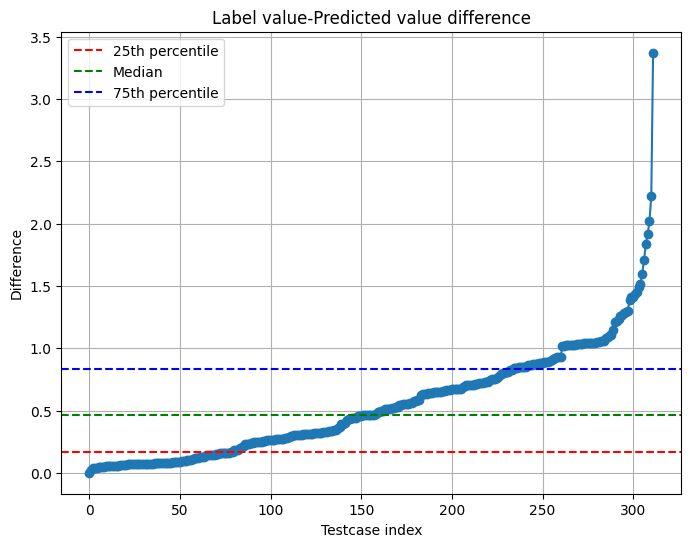

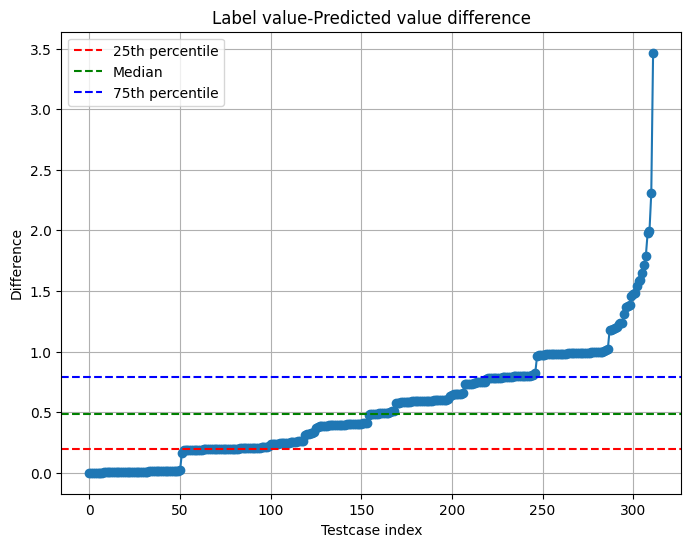

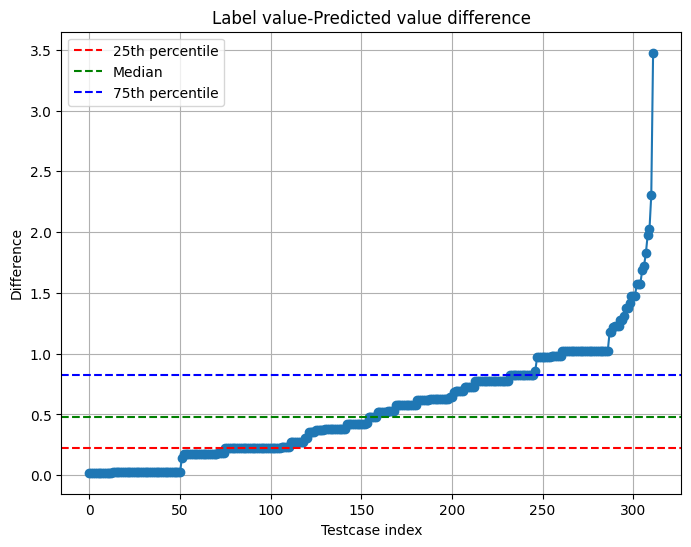

In [80]:

import warnings
warnings.filterwarnings('ignore')
import os

# Interval time: 1800, 7200, 21600, 36000
# Learning rate 0.1, 0.05, 0.001, 0.0005
# Hidden_size 2, 4, 10, 15, 25, 35
# Num layers 1, 2, 4,8

n_epochs = 80 # 1000 epochs
learning_rates = [0.001]

input_size = 21 # number of features
hidden_sizes = [5, 15, 25] # number of features in hidden state
num_layers_list = [1, 2, 4] # number of stacked lstm layers

num_classes = 1 # number of output classes 

for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        for num_layers in num_layers_list:
            print(f"Testing learning rate: {learning_rate}, features in hidden layer {hidden_size}, stacked LSTM {num_layers}")

            folder = "./pt"+str(interval_time)+"_lr"+str(learning_rate).replace(".", "dot")+"_hs"+str(hidden_size)+"_nl"+str(num_layers)+"/"
            os.makedirs(folder)

            lstm = LSTM(num_classes, 
                        input_size, 
                        hidden_size, 
                        num_layers)

            loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
            optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

            prediction, result = training_loop(n_epochs=n_epochs,
                        lstm=lstm,
                        optimiser=optimiser,
                        loss_fn=loss_fn,
                        train_loader = train_loader,
                        test_loader = test_loader)

            prediction = np.array([tensor.item() for tensor in prediction])
            result = np.array([tensor.item() for tensor in result])
            prediction = (10-1)*prediction+1
            result = (10-1)*result+1

            #print("Expected std: "+str(np.std(result)))
            #print("Infer std: "+str(np.std(prediction)))
            #
            #print("Learning rate: "+str(learning_rate))
            #print("Hidden Size: "+str(hidden_size))
            #print("LSTM layers: "+str(num_layers))
            #print("Loss function: MSE")
            #
            #print("Number of different test predictions: "+str(len(np.unique(prediction))))
            #print("First 10 values: "+str(prediction[:10]))

            np.savetxt(folder+"result.txt", result, fmt='%.2f')
            np.savetxt(folder+"prediction.txt", prediction, fmt='%.2f')
            import matplotlib.pyplot as plt

            delta = abs(prediction - result)
            mse = np.mean(np.square(delta))
            mae = np.mean(delta)
            delta = np.sort(delta)

            # Compute percentiles
            percentile_25 = np.percentile(delta, 25)
            median = np.percentile(delta, 50)
            percentile_75 = np.percentile(delta, 75)

            # Plot the sorted data
            plt.figure(figsize=(8, 6))
            plt.plot(range(len(delta)), delta, marker='o', linestyle='-')
            plt.ylabel('Difference')
            plt.xlabel('Testcase index')
            plt.title('Label value-Predicted value difference')

            # Plot percentiles
            plt.axhline(y=percentile_25, color='r', linestyle='--', label='25th percentile')
            plt.axhline(y=median, color='g', linestyle='--', label='Median')
            plt.axhline(y=percentile_75, color='b', linestyle='--', label='75th percentile')

            plt.legend()
            plt.grid(True)
            #plt.show()

            #print("25th percentile:", percentile_25)
            #print("Median:", median)
            #print("75th percentile:", percentile_75)
            print("MSE: "+str(mse))
            print("MAE: "+str(mae))

            plt.savefig(folder+"plot_original.png")
            np.savetxt(folder+"MSE_original.txt", np.array([mse]), fmt='%.3f')
            np.savetxt(folder+"MAE_original.txt", np.array([mae]), fmt='%.3f')
            # Round the arrays
            prediction_rounded = np.round(prediction)
            result_rounded = np.round(result)

            # Compute differences
            delta = np.abs(prediction_rounded - result_rounded)
            mse = np.mean(np.square(delta))
            mae = np.mean(delta)
            delta_sorted = np.sort(delta)

            # Compute percentiles
            percentile_25 = np.percentile(delta_sorted, 25)
            median = np.percentile(delta_sorted, 50)
            percentile_75 = np.percentile(delta_sorted, 75)

            # Plot the sorted data
            #plt.figure(figsize=(8, 6))
            #plt.plot(range(len(delta_sorted)), delta_sorted, marker='o', linestyle='-')
            #plt.ylabel('Difference')
            #plt.xlabel('Testcase index')
            #plt.title('Label value - Predicted value difference (Rounded)')
#
            #plt.legend()
            #plt.grid(True)
            #plt.show()
            #
            #print("25th percentile:", percentile_25)
            #print("Median:", median)
            #print("75th percentile:", percentile_75)
            #print("MSE:", mse)

            #plt.savefig(folder+"plot_rounded.png")
            np.savetxt(folder+"MSE_rounded.txt", np.array([mse]), fmt='%.3f')
            np.savetxt(folder+"MAE_rounded.txt", np.array([mae]), fmt='%.3f')

            result_mean = np.mean(result)

            # Compute the sum of squares of residuals (SS_res)
            ss_res = np.sum((result - prediction) ** 2)

            # Compute the total sum of squares (SS_tot)
            ss_tot = np.sum((result - result_mean) ** 2)

            # Compute R-squared
            r_squared = 1 - (ss_res / ss_tot)

            print("R-squared:", r_squared)

            np.savetxt(folder+"R_squared.txt", np.array([r_squared]), fmt='%.3f')